In [204]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
ecm = make_scorer(mean_absolute_error)
k_fold_value = 5

raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index).drop('SampleNo', axis=1).drop('x6', axis=1)

columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'Y']
predictors = ['x1', 'x2', 'x3', 'x4', 'x5']
act_pred = ['x1', 'x3', 'x5']
all_test_results = {}

features, labels = dataset[predictors], dataset['Y']

In [205]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

class ModelResult:
    def __init__(self, info_dict: dict):
        self.model = info_dict['model']
        self.arg = info_dict['arg']
        self.predictors = info_dict['predictors']
        self.predicted = info_dict['predicted']
        self.error = info_dict['error']

def single_linear_regression_cv(x, y, arg=None, inputs=None):
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=pd.DataFrame(x[inputs], columns=[inputs]),
                                y=y,
                                cv=5,
                                scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=pd.DataFrame(x[inputs], columns=[inputs]),
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'single_linear_regression',
                        'arg': '',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})

def polynomial_regression_cv(x, y, arg=None, inputs=predictors):
    poly_features = PolynomialFeatures(degree=arg, include_bias=False).fit_transform(x)
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=poly_features,
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=poly_features,
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'polynomial_regression',
                        'arg': f'order={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})

In [206]:
target_set_k_fold = [{'train': pd.DataFrame(np.array(dataset)[train_i], columns=columns),
                      'test': pd.DataFrame(np.array(dataset)[test_i], columns=columns)}
                     for train_i, test_i in KFold(n_splits=k_fold_value, random_state=None, shuffle=False).split(dataset)]

def split_by_threshold(ss, predictor, threshold):
    return ss[ss[predictor] < threshold], ss[ss[predictor] >= threshold]

def subplot_for_five(data):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes[1][2].set_visible(False)
    axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
    axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])
    for i in range(len(predictors)):
        sns.scatterplot(ax=axes[i // 3, i % 3], x=data[predictors[i]], y=data['Y'], alpha=0.5, color='b')

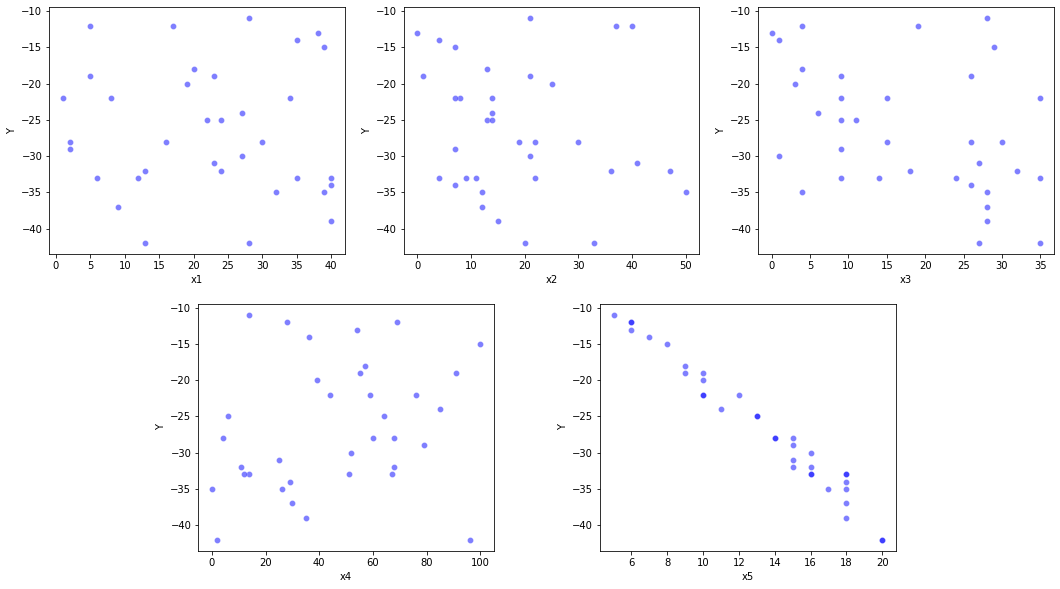

In [207]:
n1_lt, n1_gt = split_by_threshold(dataset, 'x5', threshold=5)

subplot_for_five(data=n1_gt)

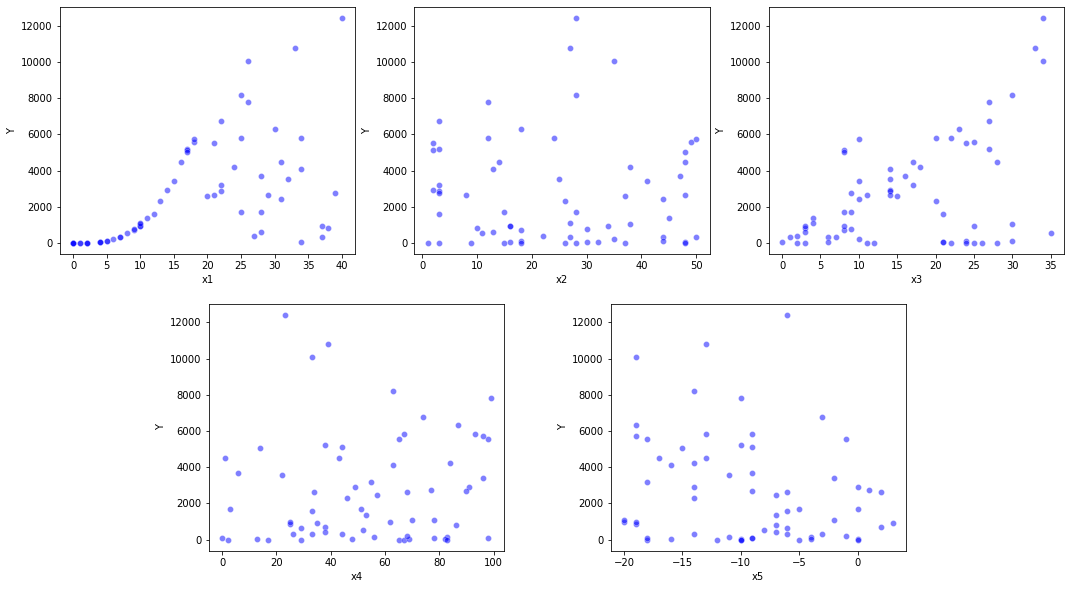

In [208]:
subplot_for_five(data=n1_lt)

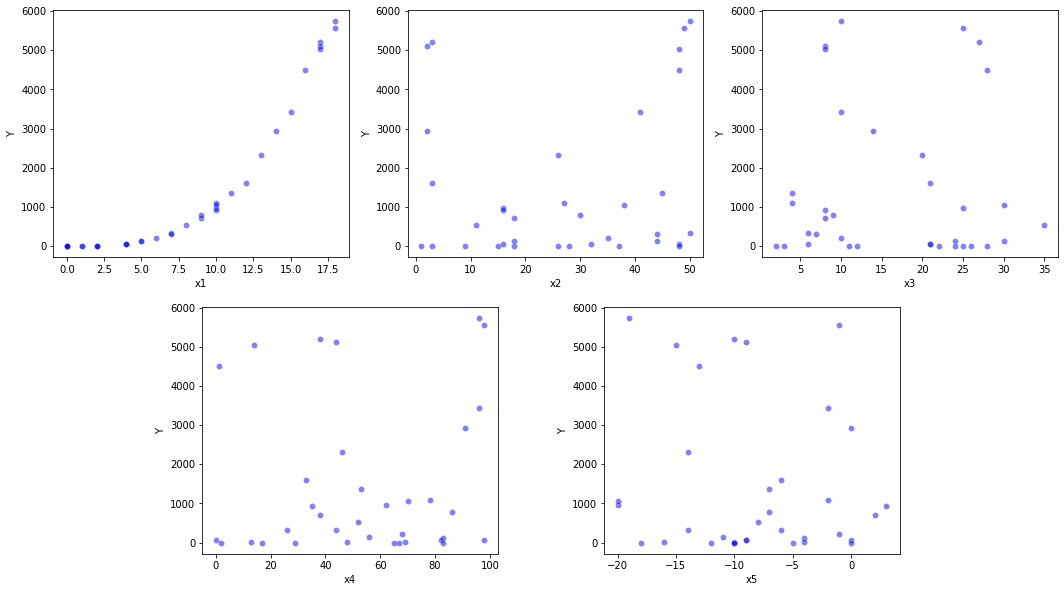

In [209]:
n2_lt, n2_gt = split_by_threshold(n1_lt, 'x1', threshold=20)

subplot_for_five(n2_lt)

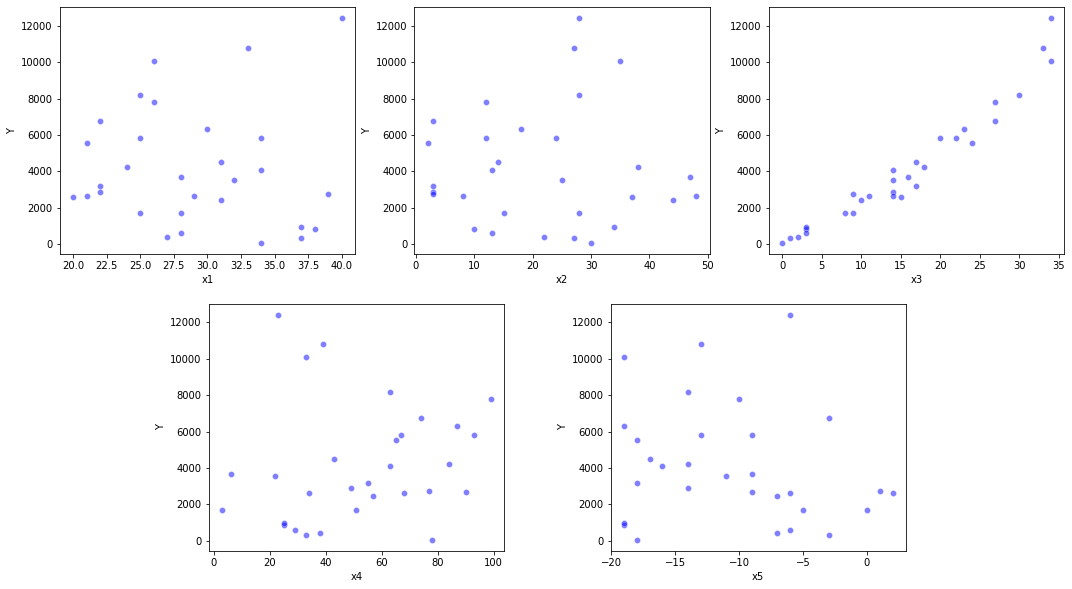

In [210]:
subplot_for_five(n2_gt)

In [211]:
# def k_fold_custom():
# # x5: x5 >= 5 -> x5            (target = c1_gt)
# # x1: x5 < 5 && x1 < 20 -> x1  (target = c2_lt)
# # x3: x5 < 5 && x1 >= 20 -> x3 (target = c2_gt)
#
#     k_fold_cv_error = 0
#     for fold in target_set_k_fold:
#         tr_1_lt, tr_1_gt = split_by_threshold(fold['train'], 'x5', threshold=5)
#         tr_2_lt, tr_2_gt = split_by_threshold(tr_1_lt, 'x1', threshold=20)
#         x5_train = tr_1_gt
#         x1_train = tr_2_lt
#         x3_train = tr_2_gt
#
#         te_1_lt, te_1_gt = split_by_threshold(fold['test'], 'x5', threshold=5)
#         te_2_lt, te_2_gt = split_by_threshold(te_1_lt, 'x1', threshold=20)
#         x5_test = te_1_gt
#         x1_test = te_2_lt
#         x3_test = te_2_gt
#
#         target_sets = [{'predictor': 'x5', 'xy_train': x5_train, 'xy_test': x5_test,
#                         'title': 'x5>=5', 'model': single_linear_regression, 'arg': None},
#                        {'predictor': 'x1', 'xy_train': x1_train, 'xy_test': x1_test,
#                         'title': 'x5<5 and x1<20', 'model': polynomial_regression, 'arg': 2},
#                        {'predictor': 'x3', 'xy_train': x3_train, 'xy_test': x3_test,
#                         'title': 'x5<5 and x1>=20', 'model': polynomial_regression, 'arg': 2}]
#
#         fig_, axes_ = plt.subplots(1, 3, figsize=(18, 5))
#
#         cv_error = 0
#         plot_i = 0
#         for target_set in target_sets:
#             target_model = target_set['model'](x_train=target_set['xy_train'][act_pred],
#                                                y_train=target_set['xy_train']['Y'],
#                                                x_test=target_set['xy_test'][act_pred],
#                                                y_test=target_set['xy_test']['Y'],
#                                                inputs=target_set['predictor'], arg=target_set['arg'])
#
#             sns.scatterplot(ax=axes_[plot_i], x=target_set['xy_train'][target_set['predictor']], y=target_set['xy_train']['Y'],
#                             alpha=0.2, color='g', label='Training Data')
#             sns.scatterplot(ax=axes_[plot_i], x=target_set['xy_test'][target_set['predictor']], y=target_set['xy_test']['Y'],
#                             color='b', label='Test Data')
#             sns.scatterplot(ax=axes_[plot_i], x=target_set['xy_test'][target_set['predictor']], y=target_model.y_predicted,
#                             color='r', label='Predicted')
#
#             cv_error += target_model.error
#             axes_[plot_i].set_title(target_set['title'])
#             plot_i += 1
#         k_fold_cv_error += cv_error
#     print(f'{k_fold_value}-Fold CV MAE = {k_fold_cv_error / k_fold_value}')

x5


,Predicted,Actual,Error
1,-22.174623,-24.0,1.825377
6,-16.169273,-15.0,-1.169273
8,-30.181756,-28.0,-2.181756
9,-12.165706,-13.0,0.834294
11,-36.187106,-33.0,-3.187106
18,-32.183539,-32.0,-0.183539
21,-36.187106,-37.0,0.812894
22,-20.235672,-19.0,-1.235672
24,-28.065345,-28.0,-0.065345
25,-30.022764,-32.0,1.977236


x1


,Predicted,Actual,Error
0,-5.475698,1.0,-6.475698
3,96.484615,121.0,-24.515385
5,772.868094,705.0,67.868094
10,1415.326931,1360.0,55.326931
13,2859.314768,2931.0,-71.685232
14,1065.039487,961.0,104.039487
15,345.101777,325.0,20.101777
17,4929.996323,5203.0,-273.003677
23,3452.044579,3429.0,23.044579
31,-24.668055,8.0,-32.668055


x3


,Predicted,Actual,Error
2,3083.227044,4092.0,-1008.772956
4,2066.186536,2441.0,-374.813464
7,471.883374,332.0,139.883374
12,4290.089905,4222.0,68.089905
16,743.125686,851.0,-107.874314
19,7699.569322,6747.0,952.569322
20,1855.172660,1704.0,151.172660
26,768.618216,962.0,-193.381784
28,2315.622161,2667.0,-351.377839
37,3098.419556,2897.0,201.419556


587.4678528278193


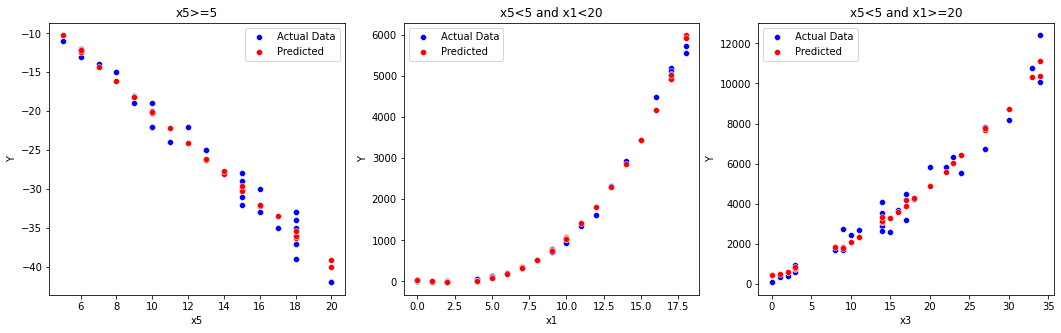

In [212]:
from IPython.core.display_functions import display

# x5: x5 >= 5 -> x5            (target = c1_gt)
# x1: x5 < 5 && x1 < 20 -> x1  (target = c2_lt)
# x3: x5 < 5 && x1 >= 20 -> x3 (target = c2_gt)

tr_1_lt, tr_1_gt = split_by_threshold(dataset, 'x5', threshold=5)
tr_2_lt, tr_2_gt = split_by_threshold(tr_1_lt, 'x1', threshold=20)

x5_data = tr_1_gt
x1_data = tr_2_lt
x3_data = tr_2_gt

# te_1_lt, te_1_gt = split_by_threshold(fold['test'], 'x5', threshold=5)
# te_2_lt, te_2_gt = split_by_threshold(te_1_lt, 'x1', threshold=20)
# x5_test = te_1_gt
# x1_test = te_2_lt
# x3_test = te_2_gt

target_sets = [{'predictor': 'x5', 'xy': x5_data,
                'title': 'x5>=5', 'model': single_linear_regression_cv, 'arg': None},
               {'predictor': 'x1', 'xy': x1_data,
                'title': 'x5<5 and x1<20', 'model': polynomial_regression_cv, 'arg': 3},
               {'predictor': 'x3', 'xy': x3_data,
                'title': 'x5<5 and x1>=20', 'model': polynomial_regression_cv, 'arg': 2}]

fig_, axes_ = plt.subplots(1, 3, figsize=(18, 5))

cv_error = 0
plot_i = 0
for target_set in target_sets:
    target_model = target_set['model'](x=target_set['xy'][[target_set['predictor']]],
                                       y=target_set['xy']['Y'],
                                       inputs=target_set['predictor'], arg=target_set['arg'])
    print(target_set['predictor'])
    error_vector = target_model.predicted - target_set['xy']['Y']
    display(pd.DataFrame({'Predicted': target_model.predicted,
                          'Actual': target_set['xy']['Y'],
                          'Error': error_vector}))
    sns.scatterplot(ax=axes_[plot_i], x=target_set['xy'][target_set['predictor']], y=target_set['xy']['Y'],
                    color='b', label='Actual Data')
    sns.scatterplot(ax=axes_[plot_i], x=target_set['xy'][target_set['predictor']], y=target_model.predicted,
                    color='r', label='Predicted')

    cv_error += target_model.error
    axes_[plot_i].set_title(target_set['title'])
    plot_i += 1
print(cv_error)